In [1]:
import numpy as np
import phoebe
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lcV = np.loadtxt('../lc.V.data')
lcB = np.loadtxt('../lc.B.data')
rv1 = np.loadtxt('../rv1.data')
rv2 = np.loadtxt('../rv2.data')

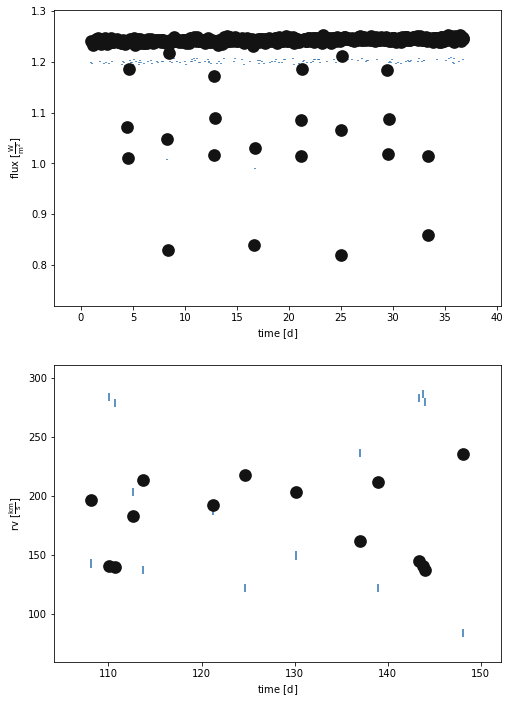

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [3]:
b = phoebe.default_binary()

b.add_dataset('lc', times = lcV[:,0], fluxes=lcV[:,1], sigmas=lcV[:,2], passband='Johnson:V', dataset='lcV')
b.add_dataset('lc', times = lcB[:,0], fluxes=lcB[:,1], sigmas=lcB[:,2], passband='Johnson:B', dataset='lcB')

b.add_dataset('rv')
#primary rv
b.set_value('times', component='primary', dataset='rv01', value=rv1[:,0])
b.set_value('rvs', component='primary', dataset='rv01', value=rv1[:,1])
b.set_value('sigmas', component='primary', dataset='rv01', value=rv1[:,2])
#secondary rv
b.set_value('times', component='secondary', dataset='rv01', value=rv2[:,0])
b.set_value('rvs', component='secondary', dataset='rv01', value=rv2[:,1])
b.set_value('sigmas', component='secondary', dataset='rv01', value=rv2[:,2])

b.plot(show=True)

#### lc periodogram

In [4]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_bls', 
             algorithm='bls', minimum_n_cycles=2, sample_mode='manual',
             sample_periods = np.linspace(5.,15.,1000),
             overwrite=True)

b.run_solver('lcperiod_bls', solution='lcperiod_bls_sol', overwrite=True)
print(b['lcperiod_bls_sol'])

ParameterSet: 10 parameters
R  period@lcperiod_bls_sol@sol...: [ 5.          5.01001001  5.02002002 ...
 14.97997998 14.98998999 15.        ] d
R  power@lcperiod_bls_sol@solu...: [1087141.19229173 1155146.3837834
  773418.4453015  ... 1270553.07227598
 1270553.07227598 1270553.07227598]
   period_factor@lcperiod_bls_...: 1.0
R  fitted_twigs@lcperiod_bls_s...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_bls_...: [8.34334334]
R  fitted_units@lcperiod_bls_s...: ['d']
   adopt_parameters@lcperiod_b...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_bls_s...: True
   comments@lcperiod_bls_sol@s...: 


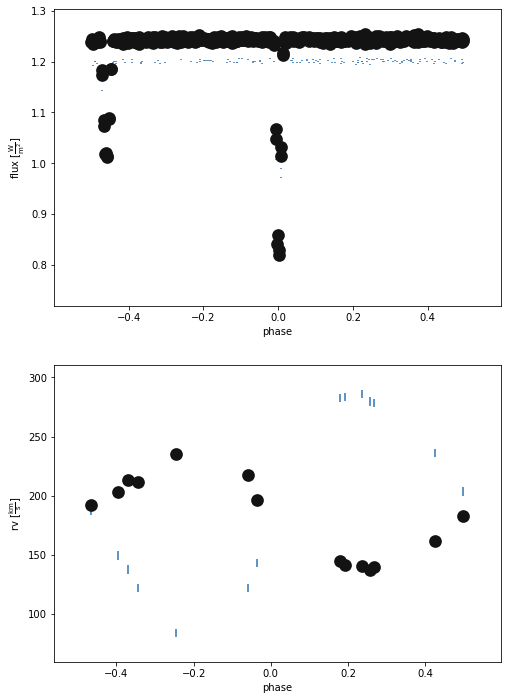

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [5]:
b.adopt_solution('lcperiod_bls_sol')
b.plot(x='phase', show=True)

Let's use only lcV for a start in the estimators and optimizers.

In [6]:
b.disable_dataset('lcB')

<ParameterSet: 20 parameters | components: secondary, binary, primary>

#### ebai

In [7]:
b.set_value_all('pblum_mode', 'dataset-scaled')
b.set_value_all('distortion_method', 'sphere')

b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 6000.0 K>

/Users/angela/miniconda3/envs/phoebe-workshop/lib/python3.8/site-packages/phoebe/solverbackends/solverbackends.py:1098: RuntimeWarning: invalid value encountered in arcsin
  fitted_values = [t0_supconj, teffratio, requivsumfrac, esinw, ecosw, np.arcsin(sini)]
100%|██████████| 472/472 [00:13<00:00, 34.71it/s]


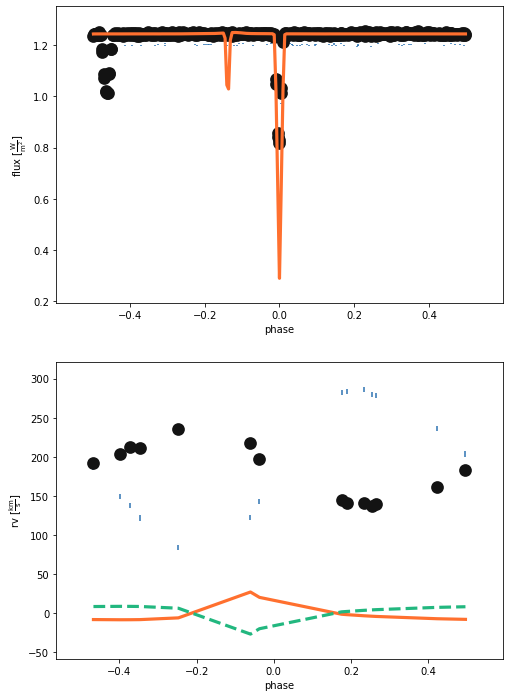

(<autofig.figure.Figure | 2 axes | 7 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [8]:
b.add_solver('estimator.ebai', solver='lc_est_ebai', phase_bin = False)
b.run_solver('lc_est_ebai', solution='lc_soln_ebai')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')
b.adopt_solution('lc_soln_ebai', adopt_parameters=b.get_value('adopt_parameters', solution='lc_soln_ebai')[:-1])
b.run_compute()
b.plot(x='phase',show=True)

#### lc_geometry

/Users/angela/miniconda3/envs/phoebe-workshop/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10312: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)
100%|██████████| 472/472 [00:13<00:00, 34.16it/s]


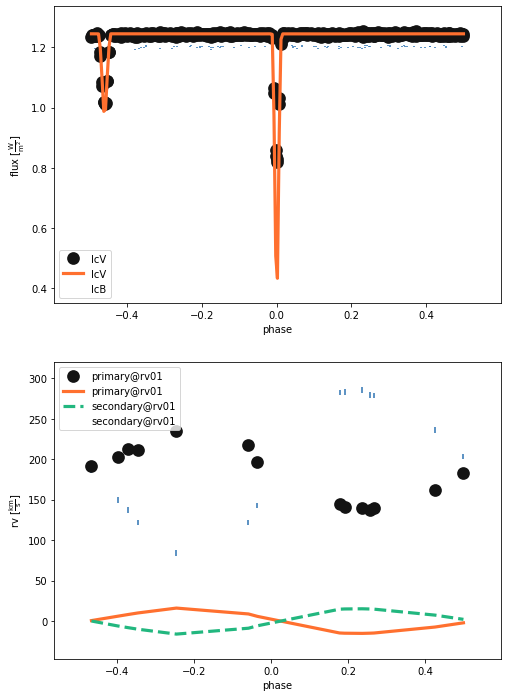

(<autofig.figure.Figure | 2 axes | 7 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [9]:
b.add_solver('estimator.lc_geometry', solver='lc_est_lcgeom', phase_bin = False)
b.run_solver('lc_est_lcgeom', solution='lc_soln_lcgeom')

b.flip_constraint('ecc', solve_for='esinw')
b.flip_constraint('per0', solve_for='ecosw')

b.adopt_solution('lc_soln_lcgeom')
b.run_compute()
b.plot(x='phase', legend=True, show=True)

#### rv geometry

100%|██████████| 472/472 [00:13<00:00, 34.30it/s]


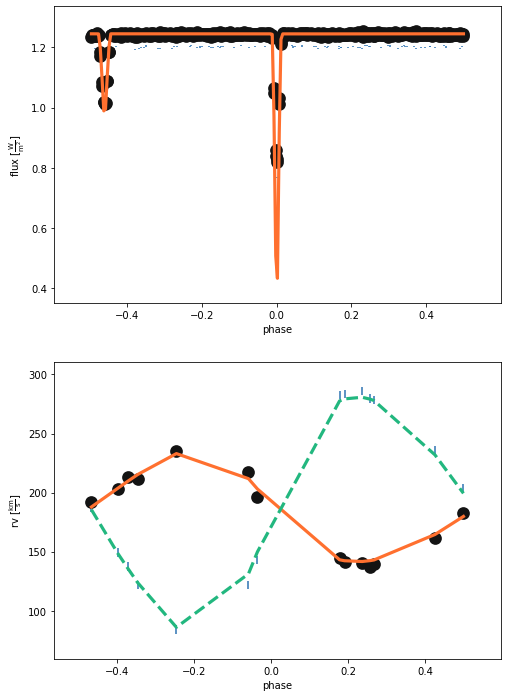

(<autofig.figure.Figure | 2 axes | 7 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [10]:
b.add_solver('estimator.rv_geometry', solver='rvgeom')
b.run_solver('rvgeom', solution='rvgeom_sol')

b['adopt_parameters@rvgeom_sol'] = ['q@binary@orbit@component', 'asini@binary@orbit@component','vgamma@system']
b.flip_constraint('asini@binary', solve_for='sma@binary')

b.adopt_solution('rvgeom_sol')
b.run_compute()
b.plot(x='phase', show=True)

In [11]:
b.save('after_estimators.bundle')

'after_estimators.bundle'